<b><ul><h3>Data Description:</h3></ul></b><br>
The actual concrete compressive strength (MPa) for a given mixture under a
specific age (days) was determined from laboratory. Data is in raw form (not
scaled). The data has 8 quantitative input variables, and 1 quantitative output
variable, and 1030 instances (observations).
<b><ul>Domain:</ul></b><p>
Cement manufacturing
<b><ul>Context:</ul></b><p>
Concrete is the most important material in civil engineering. The concrete
compressive strength is a highly nonlinear function of age and ingredients.
These ingredients include cement, blast furnace slag, fly ash, water,
superplasticizer, coarse aggregate, and fine aggregate.

## Importing Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import scipy.stats as stats
import numpy as np
from pandas.api.types import is_numeric_dtype
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gamma
from sklearn.preprocessing import StandardScaler
sns.set(color_codes=True)
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
%matplotlib inline

## Functions for EDA

In [2]:
def Distribution_Continous_Variables(series,color,title):
    plt.figure(figsize=(10, 5))
    sns.distplot(series, color = color).set_title(title)
    
def Print_Summary(series,title,var):
    print(title)
    print('Count = {1}'.format(var,len(series)))
    print('Mean of {0} = {1}'.format(var,series.mean()))
    print('Median of {0} = {1}'.format(var,series.median()))
    print('Mode of {0} = {1}'.format(var,series.mode().values[0]))
    print('Skewness of {0} = {1}'.format(var, series.skew()))
    print('Excess Kurtosis of {0} = {1}'.format(var,series.kurtosis()))
    print(100*"*")

def Coeff_Variation(series,title,var):
    print('Coefficient of Variation of {0} = {2}'.format(var,title,(series.std()/series.mean())*100))

def BoxPlot(**kwargs):
    plt.figure(figsize=(10, 5))
    sns.boxplot(x = kwargs['x'], \
                y = kwargs['y'], \
                data = kwargs['data'], \
                color = kwargs['color'], \
                hue = kwargs['hue']).set_title(kwargs['title'])    

def ViolinPlot(**kwargs):
    plt.figure(figsize=(10, 5))
    sns.violinplot(x = kwargs['x'], \
                y = kwargs['y'], \
                data = kwargs['data'], \
                color = kwargs['color'], \
                hue = kwargs['hue']).set_title(kwargs['title']) 
    
        
def CountPlot(**kwargs):
    plt.figure(figsize=(10, 5))
    sns.countplot(y=kwargs['y'], \
                    hue=kwargs['hue'], \
                    data=kwargs['data']).set_title(kwargs['title'])

def calc_vif(X):

    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


def backwardElimination(x, Y, significance_level, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > significance_level:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j] == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
    
def age_bin(df):
    if df.age <= 30:
        return '1 month'
    if df.age > 30 and df.age <= 60 :
        return '2 months'
    if df.age > 60 and df.age <= 90 :
        return '3 months'
    if df.age > 90 and df.age <= 120 :
        return '4 months'
    if df.age > 120 and df.age <= 150 :
        return '5 months'
    if df.age > 150 and df.age <= 180 :
        return '6 months'
    if df.age > 180 and df.age <= 210 :
        return '7 months'
    if df.age > 210 and df.age <= 240 :
        return '8 months'
    if df.age > 240 and df.age <= 270 :
        return '9 months'
    if df.age > 270 and df.age <= 300 :
        return '10 months'
    if df.age > 300 and df.age <= 330 :
        return '11 months'
    if df.age > 330 :
        return '12 months'  

## Importing the data

In [3]:
df = pd.read_csv("concrete.csv")

## Exploratory Data Analysis

In [4]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


### Univariate Analysis

In [6]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
age             1030 non-null int64
strength        1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


<b>Observations :</b><li>All the features (dependent or independent) are continous in nature. <li>This means that we would have to do univariate and multivariate analysis of each of these features to clearly understand the distribution and hence draw the insights.<li>Based on all the continous features we have to predict the strength of the concrete.

### Distribution of continous variables

### Analysis of Cement

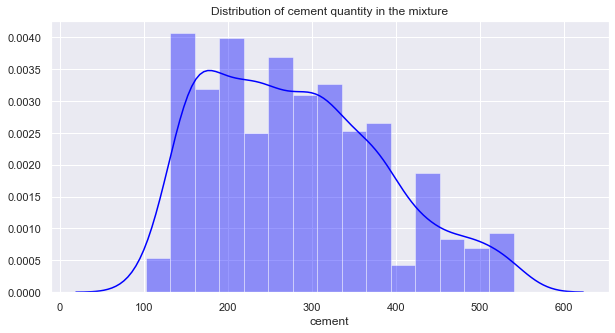

In [7]:
Distribution_Continous_Variables(df['cement'],'blue','Distribution of cement quantity in the mixture')

#### Boxplot

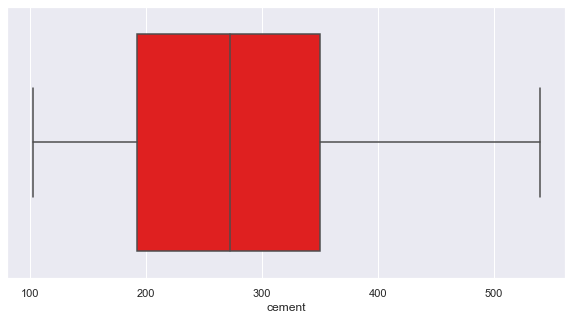

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['cement'],color='Red')

In [9]:
df['cement'].describe().T

count    1030.000000
mean      281.167864
std       104.506364
min       102.000000
25%       192.375000
50%       272.900000
75%       350.000000
max       540.000000
Name: cement, dtype: float64

In [10]:
Print_Summary(df['cement'],'Summary of cement','Cement Quantity')


Summary of cement
Count = 1030
Mean of Cement Quantity = 281.1678640776698
Median of Cement Quantity = 272.9
Mode of Cement Quantity = 362.6
Skewness of Cement Quantity = 0.5094811788717731
Excess Kurtosis of Cement Quantity = -0.5206522844987744
****************************************************************************************************


In [11]:
Coeff_Variation(df['cement'],'','Cement Quantity')

Coefficient of Variation of Cement Quantity = 37.16867318305855


<b>Observations :</b> <li>The cement quantity data above does not seem to be skewed and is almost normally distributed since the skewness and excess kurtosis values are near 0. <li>From boxlot it can be inferred that our data doesn't seem to possess any outliers when calculated through IQR method
    

### Analysis of Slag

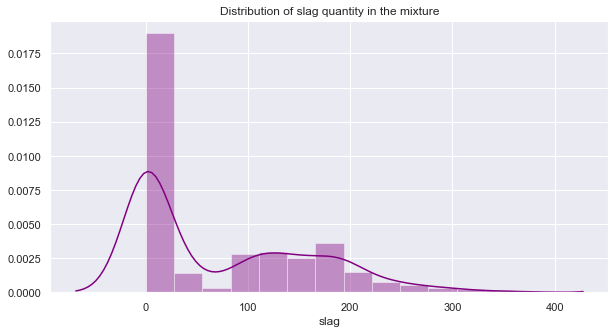

In [12]:
Distribution_Continous_Variables(df['slag'],'purple','Distribution of slag quantity in the mixture')

#### Boxplot

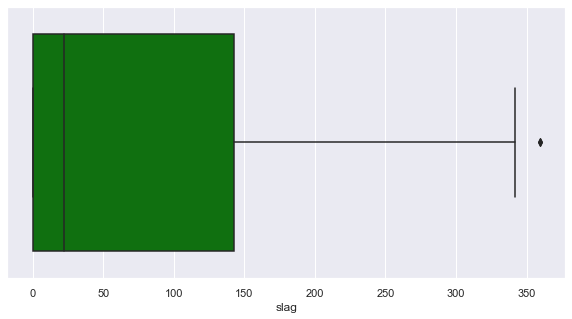

In [13]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['slag'],color='green')

In [14]:
df['slag'].describe().T

count    1030.000000
mean       73.895825
std        86.279342
min         0.000000
25%         0.000000
50%        22.000000
75%       142.950000
max       359.400000
Name: slag, dtype: float64

In [15]:
Print_Summary(df['slag'],'Summary of slag','Slag Quantity')


Summary of slag
Count = 1030
Mean of Slag Quantity = 73.89582524271844
Median of Slag Quantity = 22.0
Mode of Slag Quantity = 0.0
Skewness of Slag Quantity = 0.8007168956061774
Excess Kurtosis of Slag Quantity = -0.5081754788835435
****************************************************************************************************


In [16]:
Coeff_Variation(df['slag'],'','Slag Quantity')

Coefficient of Variation of Slag Quantity = 116.75807322634535


<b>Observations :</b> <li>The slag quantity is not normally distributed and it is skewed to the right as skewness is nearly +1 and mean median mode are not equal. <li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on the higher end.
    

### Analysis of Ash

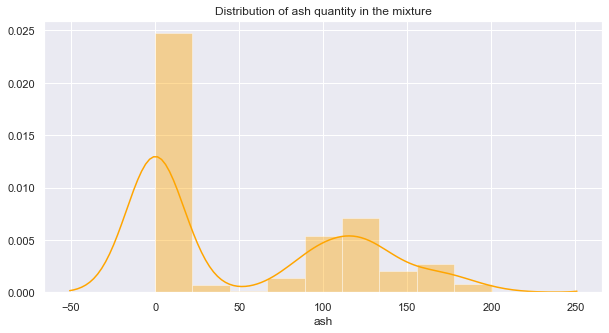

In [17]:
Distribution_Continous_Variables(df['ash'],'orange','Distribution of ash quantity in the mixture')

#### Boxplot

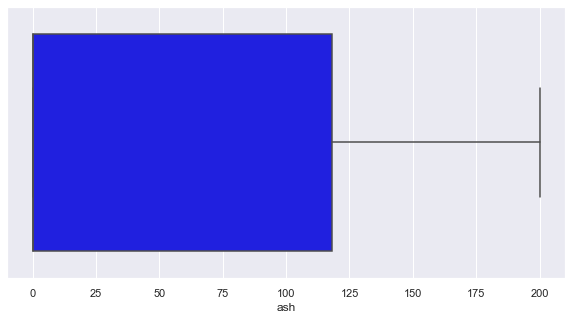

In [18]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['ash'],color='blue')

In [19]:
df['ash'].describe().T

count    1030.000000
mean       54.188350
std        63.997004
min         0.000000
25%         0.000000
50%         0.000000
75%       118.300000
max       200.100000
Name: ash, dtype: float64

In [20]:
Print_Summary(df['ash'],'Summary of ash','Ash Quantity')


Summary of ash
Count = 1030
Mean of Ash Quantity = 54.188349514563086
Median of Ash Quantity = 0.0
Mode of Ash Quantity = 0.0
Skewness of Ash Quantity = 0.5373539058066844
Excess Kurtosis of Ash Quantity = -1.3287464346799722
****************************************************************************************************


In [21]:
Coeff_Variation(df['ash'],'','Ash Quantity')

Coefficient of Variation of Ash Quantity = 118.10103966257319


<b>Observations :</b> <li>The Ash quantity is not normally distributed as its excess kurtosis is nearly -1 and mean median mode are not equal. <li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on the higher end.<li> It also contains null values.
    

### Analysis of Water

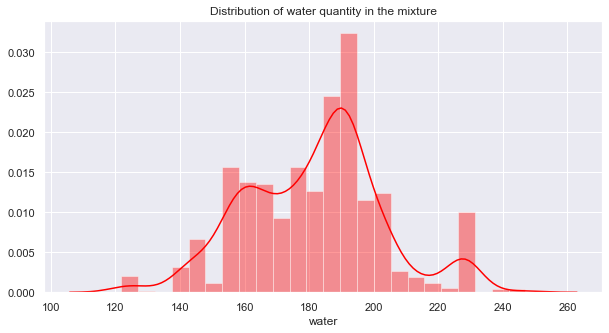

In [22]:
Distribution_Continous_Variables(df['water'],'red','Distribution of water quantity in the mixture')

#### Boxplot

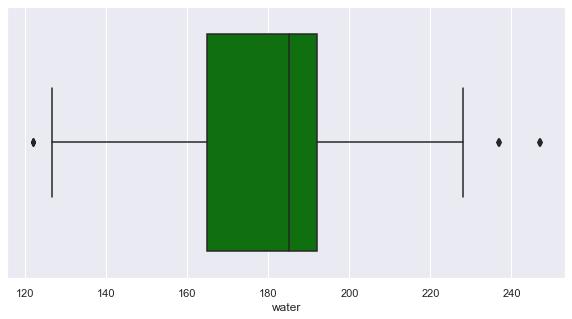

In [23]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['water'],color='green')

In [24]:
df['water'].describe().T

count    1030.000000
mean      181.567282
std        21.354219
min       121.800000
25%       164.900000
50%       185.000000
75%       192.000000
max       247.000000
Name: water, dtype: float64

In [25]:
Print_Summary(df['water'],'Summary of water','Water Quantity')


Summary of water
Count = 1030
Mean of Water Quantity = 181.56728155339798
Median of Water Quantity = 185.0
Mode of Water Quantity = 192.0
Skewness of Water Quantity = 0.07462838428549402
Excess Kurtosis of Water Quantity = 0.1220816743945825
****************************************************************************************************


In [26]:
Coeff_Variation(df['water'],'','Water Quantity')

Coefficient of Variation of Water Quantity = 11.761049888689493


<b>Observations :</b> <li>The water quantity is nearly normally distributed as its excess kurtosis and skewness values is nearly 0 and mean median mode are nearly equal. <li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on the lower end.
    

### Analysis of superplastic

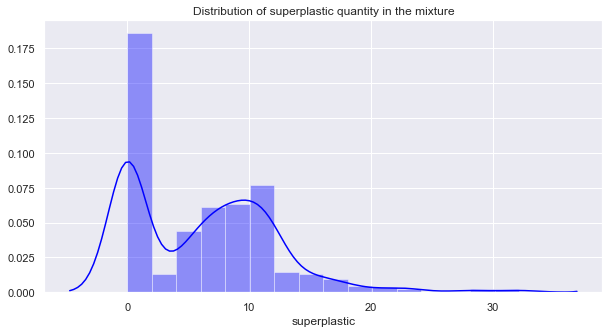

In [27]:
Distribution_Continous_Variables(df['superplastic'],'blue','Distribution of superplastic quantity in the mixture')

#### Boxplot

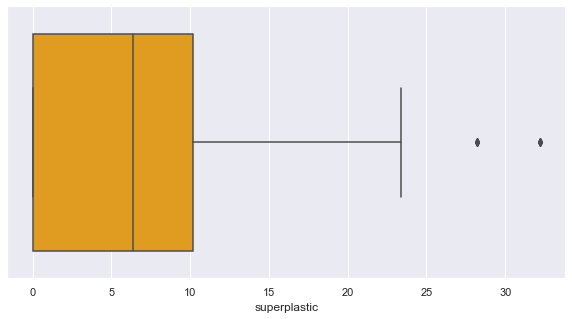

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['superplastic'],color='orange')

In [29]:
df['superplastic'].describe().T

count    1030.000000
mean        6.204660
std         5.973841
min         0.000000
25%         0.000000
50%         6.400000
75%        10.200000
max        32.200000
Name: superplastic, dtype: float64

In [30]:
Print_Summary(df['superplastic'],'Summary of superplastic','superplastic Quantity')


Summary of superplastic
Count = 1030
Mean of superplastic Quantity = 6.204660194174756
Median of superplastic Quantity = 6.4
Mode of superplastic Quantity = 0.0
Skewness of superplastic Quantity = 0.9072025748672466
Excess Kurtosis of superplastic Quantity = 1.4112689653489738
****************************************************************************************************


In [31]:
Coeff_Variation(df['superplastic'],'','superplastic Quantity')

Coefficient of Variation of superplastic Quantity = 96.27991228422223


<b>Observations :</b> <li>The superplastic quantity is not normally distributed and is skewed to the right <li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on the higher end.
    

### Analysis of age

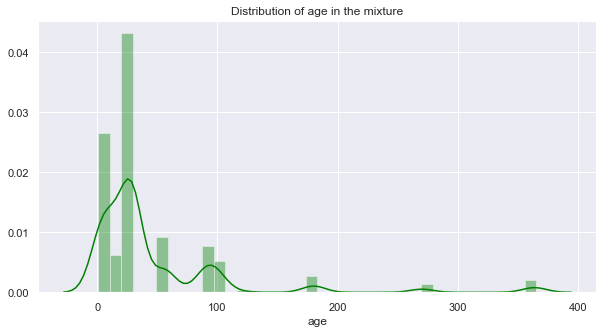

In [32]:
Distribution_Continous_Variables(df['age'],'green','Distribution of age in the mixture')

#### Boxplot

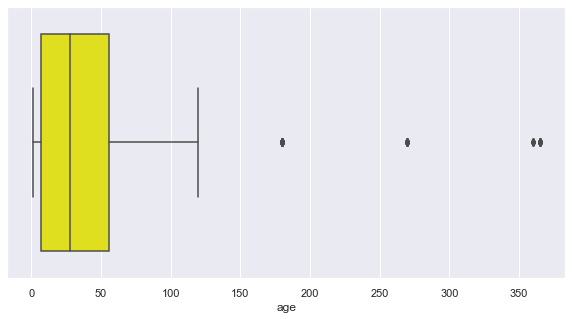

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['age'],color='yellow')

In [34]:

df['age_in_months'] = df.apply(lambda df:age_bin(df) , axis=1)

1 month      749
2 months      91
4 months      77
3 months      54
6 months      26
12 months     20
9 months      13
Name: age_in_months, dtype: int64


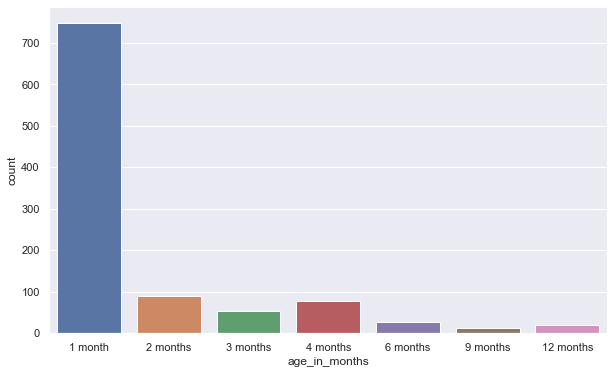

In [35]:
plt.figure(figsize=(10, 6))
sns.countplot(df['age_in_months'], order = ['1 month', '2 months', '3 months', '4 months', '6 months', '9 months', '12 months'])
print(df['age_in_months'].value_counts())

In [36]:
df['age'].describe().T

count    1030.000000
mean       45.662136
std        63.169912
min         1.000000
25%         7.000000
50%        28.000000
75%        56.000000
max       365.000000
Name: age, dtype: float64

In [37]:
Print_Summary(df['age'],'Summary of age','age Quantity')


Summary of age
Count = 1030
Mean of age Quantity = 45.662135922330094
Median of age Quantity = 28.0
Mode of age Quantity = 28
Skewness of age Quantity = 3.2691774006345895
Excess Kurtosis of age Quantity = 12.168988978672088
****************************************************************************************************


In [38]:
Coeff_Variation(df['age'],'','age')

Coefficient of Variation of age = 138.34199891236557


<b>Observations :</b> <li>The age is not normally distributed and is heavily skewed to the right <li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on the higher end.
    

### Analysis of fineagg

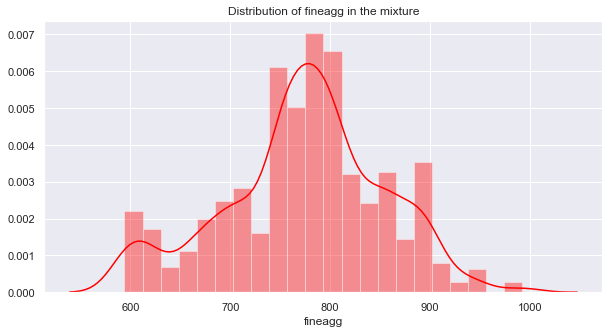

In [39]:
Distribution_Continous_Variables(df['fineagg'],'red','Distribution of fineagg in the mixture')

#### Boxplot

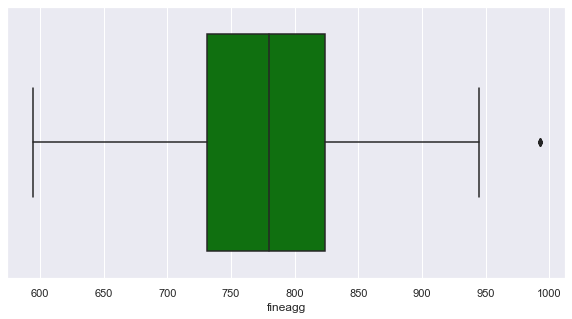

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['fineagg'],color='green')

In [41]:
df['fineagg'].describe().T

count    1030.000000
mean      773.580485
std        80.175980
min       594.000000
25%       730.950000
50%       779.500000
75%       824.000000
max       992.600000
Name: fineagg, dtype: float64

In [42]:
Print_Summary(df['fineagg'],'Summary of fineagg','fineagg Quantity')


Summary of fineagg
Count = 1030
Mean of fineagg Quantity = 773.5804854368932
Median of fineagg Quantity = 779.5
Mode of fineagg Quantity = 594.0
Skewness of fineagg Quantity = -0.25300959769707143
Excess Kurtosis of fineagg Quantity = -0.10217698932117969
****************************************************************************************************


In [43]:
Coeff_Variation(df['fineagg'],'','fineagg Quantity')

Coefficient of Variation of fineagg Quantity = 10.364271288090162


<b>Observations :</b> <li>The fineagg quantity is nearly normally distributed <li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on the lower end.
    

### Analysis of coarseagg

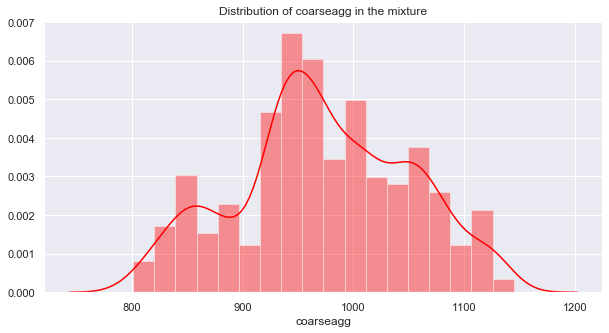

In [44]:
Distribution_Continous_Variables(df['coarseagg'],'red','Distribution of coarseagg in the mixture')

#### Boxplot

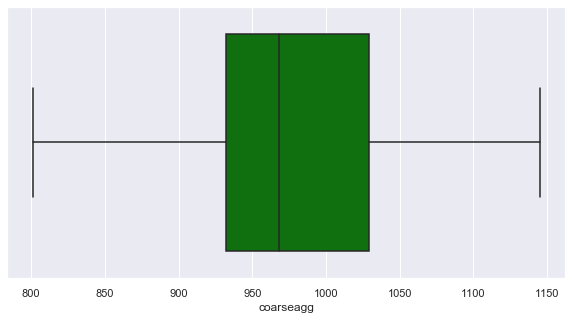

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['coarseagg'],color='green')

In [46]:
df['coarseagg'].describe().T

count    1030.000000
mean      972.918932
std        77.753954
min       801.000000
25%       932.000000
50%       968.000000
75%      1029.400000
max      1145.000000
Name: coarseagg, dtype: float64

In [47]:
Print_Summary(df['coarseagg'],'Summary of coarseagg','coarseagg Quantity')


Summary of coarseagg
Count = 1030
Mean of coarseagg Quantity = 972.918932038835
Median of coarseagg Quantity = 968.0
Mode of coarseagg Quantity = 932.0
Skewness of coarseagg Quantity = -0.04021974481106704
Excess Kurtosis of coarseagg Quantity = -0.5990161032185641
****************************************************************************************************


In [48]:
Coeff_Variation(df['coarseagg'],'','coarseagg Quantity')

Coefficient of Variation of coarseagg Quantity = 7.991822484508631


<b>Observations :</b> <li>The coarseagg quantity is nearly normally distributed <li>From boxlot it can be inferred that our data does not contain outliers when calculated through IQR method.<li> Even the coefficient of variation is on lower end.
    

### Analysis of strength

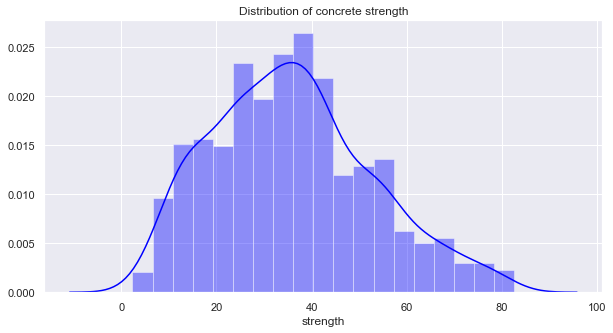

In [49]:
Distribution_Continous_Variables(df['strength'],'blue','Distribution of concrete strength')

#### Boxplot

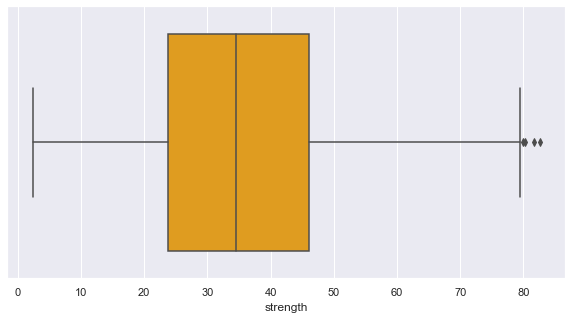

In [50]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['strength'],color='orange')

In [51]:
df['strength'].describe().T

count    1030.000000
mean       35.817961
std        16.705742
min         2.330000
25%        23.710000
50%        34.445000
75%        46.135000
max        82.600000
Name: strength, dtype: float64

In [52]:
Print_Summary(df['strength'],'Summary of strength','Concrete strength')


Summary of strength
Count = 1030
Mean of Concrete strength = 35.81796116504854
Median of Concrete strength = 34.445
Mode of Concrete strength = 33.4
Skewness of Concrete strength = 0.41697728841071807
Excess Kurtosis of Concrete strength = -0.3137248604469969
****************************************************************************************************


In [53]:
Coeff_Variation(df['strength'],'','strength Quantity')

Coefficient of Variation of strength Quantity = 46.640683664077756


<b>Observations :</b> <li>The concrete strength is nearly normally distributed with skwenees and excess kurtosis nearly 0 and mean , median, mode is also equal<li>From boxlot it can be inferred that our data does contain outliers when calculated through IQR method.
    

### Finding missing values

In [54]:
df.isnull().values.any()

False

In [55]:
df.isnull().sum()

cement           0
slag             0
ash              0
water            0
superplastic     0
coarseagg        0
fineagg          0
age              0
strength         0
age_in_months    0
dtype: int64

### Looking out for features which have values = 0

In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


<b> Final Inference : </b> <li>From the univariate analysis above we can observe that the distribution of Slag , Ash , superplastic and Age are skewed to the right.<li> Except cement and strength all the features contain outliers when calculated through IQR method.<li> We would first try to train our model with ensemble regressors(since it reduces the affect of outliers) and would compare its test evalution metric with that of non ensemble regressors, if in case there is a massive difference then we will try to remove or impute the outliers and train normal regressors again. If the difference is not that massive , then we may conclude that outliers might not have that much affect on our model building

### Multivariate Analysis

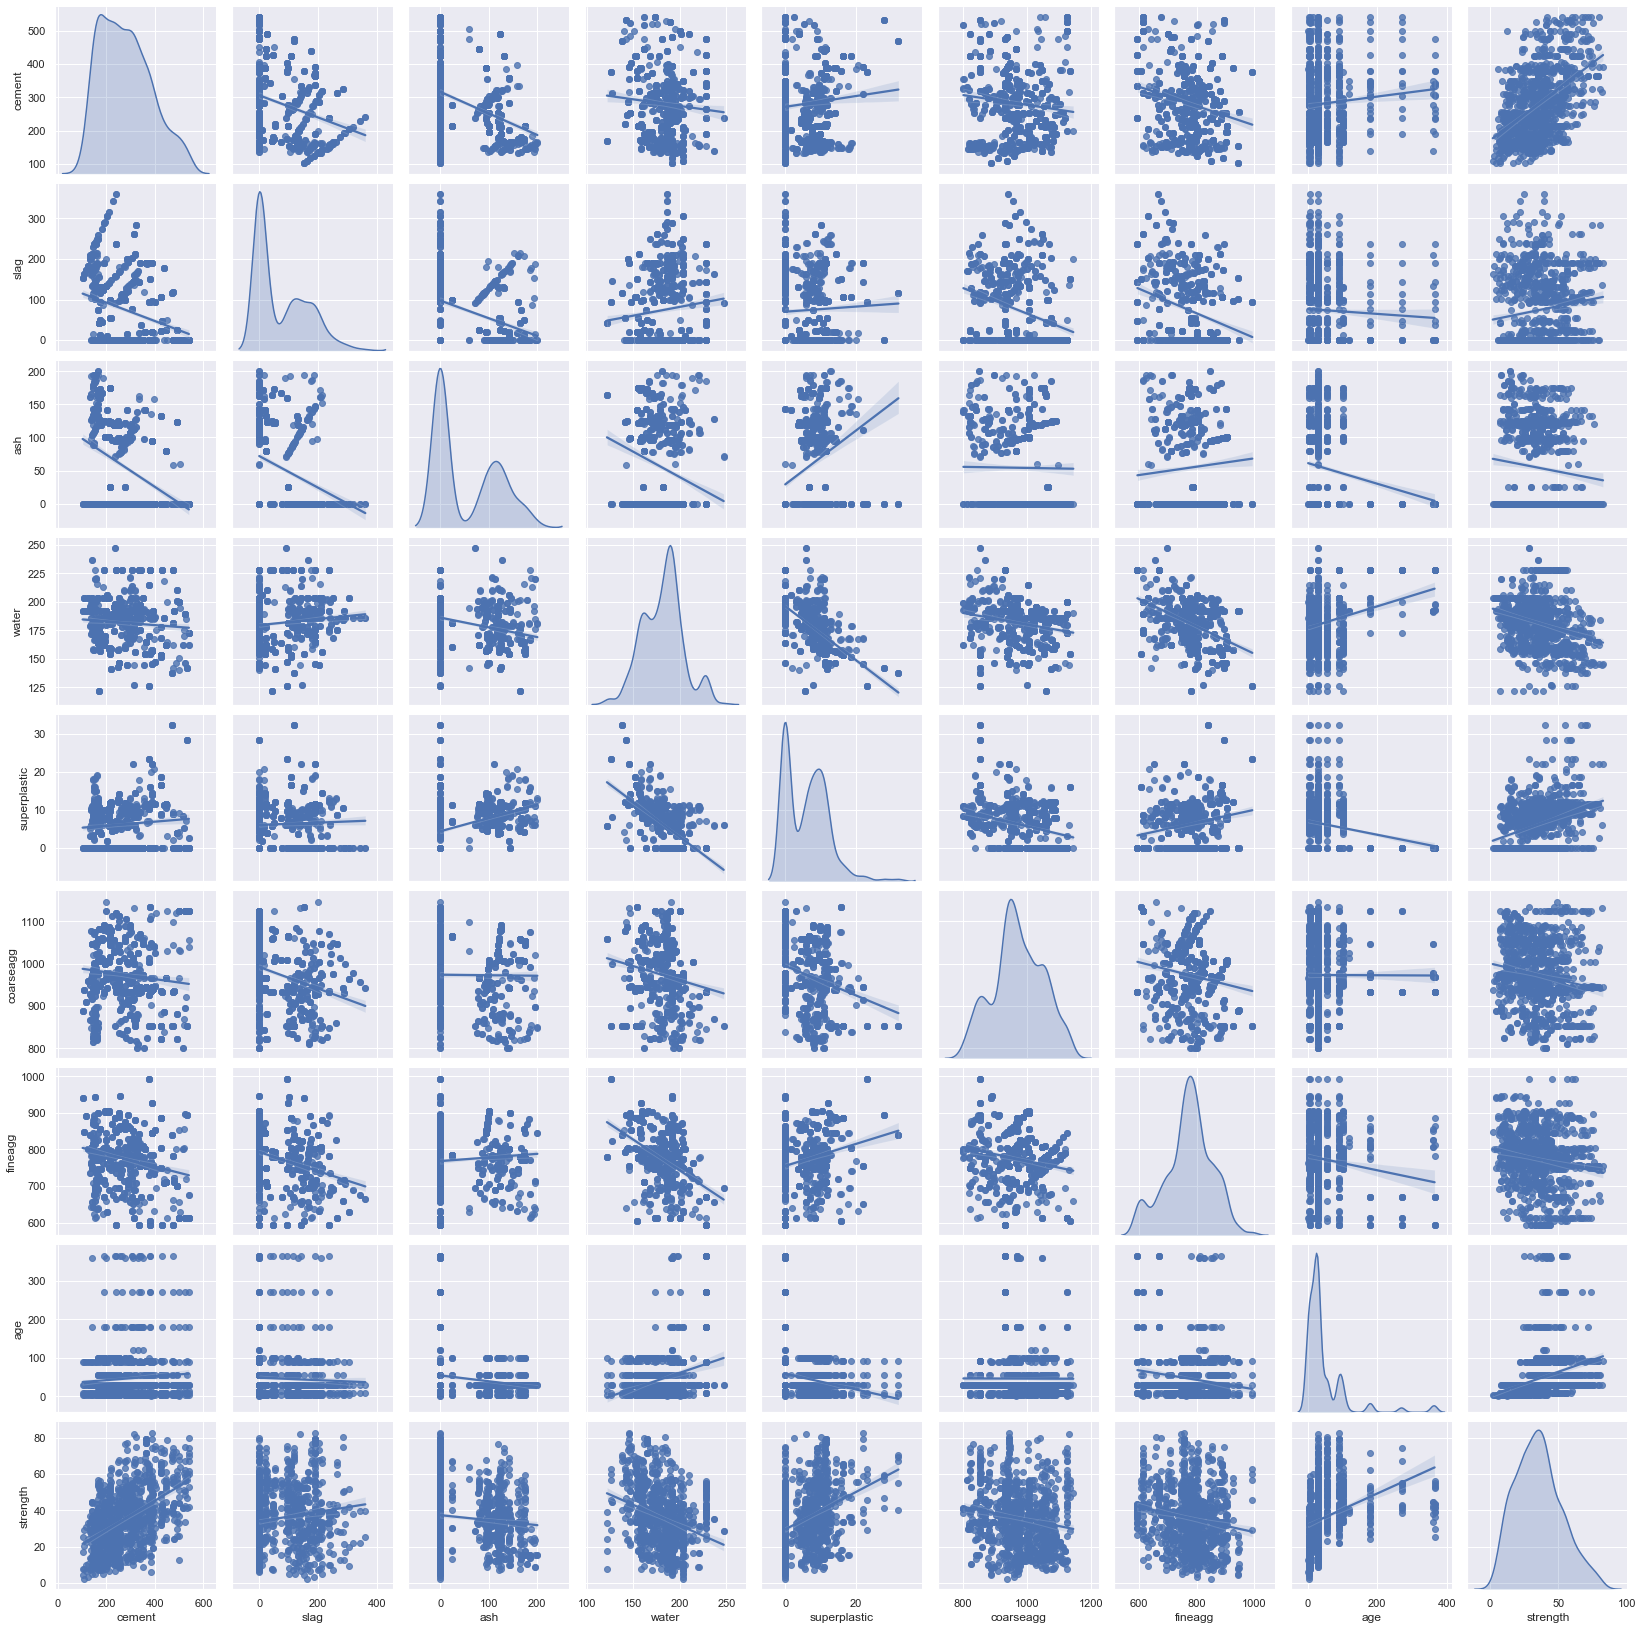

In [57]:
sns.pairplot(df, kind = 'reg', diag_kind = 'kde')

#### Plotting correlation matrix

(9.0, 0.0)

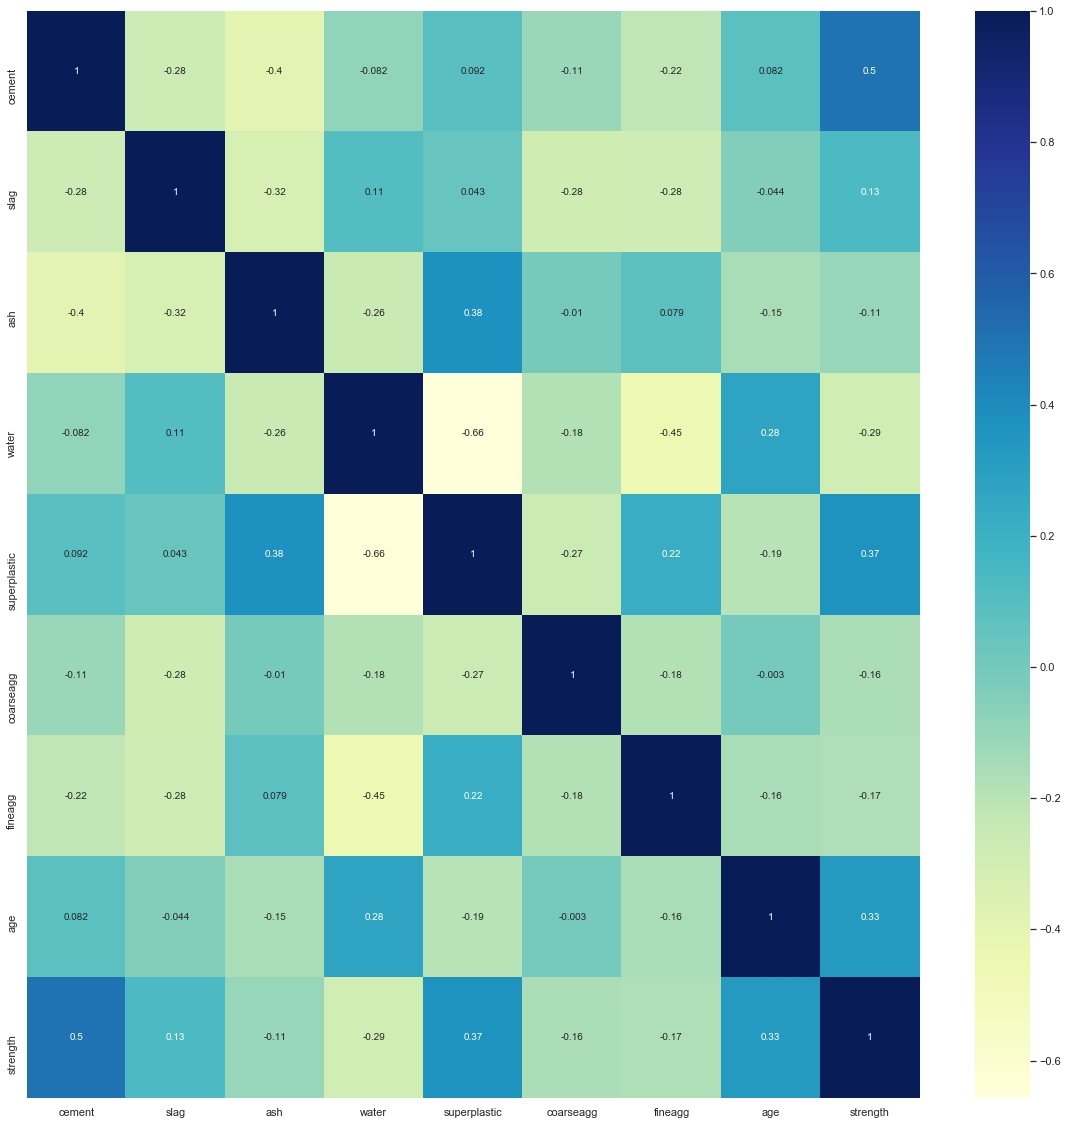

In [58]:
plt.figure(figsize=(20, 20))
df_corr = df.corr(method='pearson')
ax = sns.heatmap(df_corr, annot=True, cmap='YlGnBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

<b>Observations: </b><li>From above we cannot observe any highly correlated features. <li> We would further consolidate this fact by applying hypothesis testing to check whether we have highly correlated features here

### Using p value to find important features

<ul><li>Our null hypothesis is that the selected features or dependent variables do not have any effect on our target or independent variable<li>We will build a naive regression model and will calculate the p values<li>If p value turns out to be higher than our significance level(let's assume 0.05) we will discard the combination of features i.e we will accept our null hypothesis for the given set of features</ul>

In [59]:
le = preprocessing.LabelEncoder()
le.fit(df['age_in_months'])

LabelEncoder()

In [60]:
df['age_in_months'] = le.transform(df['age_in_months'])

In [61]:
x_ols = df.drop(columns=['strength']).values
y_ols = df['strength']
significance_level = 0.05
selected_columns = df.drop(columns=['strength']).columns
data, selected_columns = backwardElimination(x_ols, y_ols, significance_level, selected_columns)

In [62]:
df.shape

(1030, 10)

In [63]:
data_pval = pd.DataFrame(data = data, columns = selected_columns)

In [64]:
data_pval.shape

(1030, 9)

In [65]:
data_pval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
cement           1030 non-null float64
slag             1030 non-null float64
ash              1030 non-null float64
water            1030 non-null float64
superplastic     1030 non-null float64
coarseagg        1030 non-null float64
fineagg          1030 non-null float64
age              1030 non-null float64
age_in_months    1030 non-null float64
dtypes: float64(9)
memory usage: 72.5 KB


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
cement           1030 non-null float64
slag             1030 non-null float64
ash              1030 non-null float64
water            1030 non-null float64
superplastic     1030 non-null float64
coarseagg        1030 non-null float64
fineagg          1030 non-null float64
age              1030 non-null int64
strength         1030 non-null float64
age_in_months    1030 non-null int32
dtypes: float64(8), int32(1), int64(1)
memory usage: 76.6 KB


<b>Observation : </b> <li>From above we can clearly observe that we do not have any highly correlated features since all the features have been retained and none fo them have been removed.<li> But still we would further analyze whether there are features that could independently determine the concrete strength. We would plot the regression plots to check it.

In [67]:
X = df.drop(columns=['strength'])
y = df['strength']

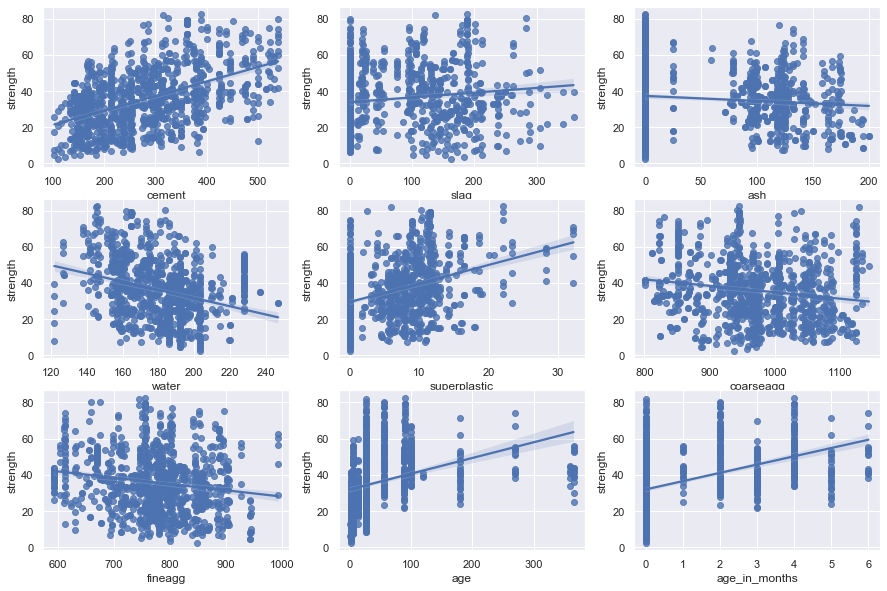

In [68]:
plt.figure(figsize=(15, 10))
col = 1
for i in df.drop(columns = 'strength').columns:
    plt.subplot(3, 3, col)
    sns.regplot(x = X[i], y = y, data = df)
    col += 1 

In [69]:
X.apply(lambda x: x.corr(y))

cement           0.497832
slag             0.134829
ash             -0.105755
water           -0.289633
superplastic     0.366079
coarseagg       -0.164935
fineagg         -0.167241
age              0.328873
age_in_months    0.424227
dtype: float64

<b>Conclusion :</b><li>From the above values we can further consolidate our null hypothesis that these features independently do not have any siginificant effect on the strength of the concrete.<li>But still features like cement, age_in_months,, superplastic can be the most important features in determining the strength of the concrete which we would further analyse in feature importance section.<li>Feature age_in_months has higher correlation with strength when compared to age so we would one hot encode age_in_months and drop feature age to train a more accurate model. 

In [70]:
df['age_in_months'] = le.inverse_transform(df['age_in_months'])

In [71]:
months = pd.get_dummies(df['age_in_months'])

In [72]:
df1 = pd.concat([df,months], axis=1, ignore_index=False)

In [73]:
df1.drop(columns = ['age','age_in_months'], inplace=True)

In [74]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 15 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
strength        1030 non-null float64
1 month         1030 non-null uint8
12 months       1030 non-null uint8
2 months        1030 non-null uint8
3 months        1030 non-null uint8
4 months        1030 non-null uint8
6 months        1030 non-null uint8
9 months        1030 non-null uint8
dtypes: float64(8), uint8(7)
memory usage: 71.5 KB


### Converting months to object datatype

In [75]:
columns = ['1 month','2 months','3 months','4 months','6 months','9 months','12 months']
df1[columns] = df1[columns].astype('object')

In [76]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 15 columns):
cement          1030 non-null float64
slag            1030 non-null float64
ash             1030 non-null float64
water           1030 non-null float64
superplastic    1030 non-null float64
coarseagg       1030 non-null float64
fineagg         1030 non-null float64
strength        1030 non-null float64
1 month         1030 non-null object
12 months       1030 non-null object
2 months        1030 non-null object
3 months        1030 non-null object
4 months        1030 non-null object
6 months        1030 non-null object
9 months        1030 non-null object
dtypes: float64(8), object(7)
memory usage: 120.8+ KB


## Transformers

### CustomStandardScaler transformer would scale the data just like standard scaler but the only difference is that it would pick only continous features to scale

In [77]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomStandardScaler( BaseEstimator, TransformerMixin ):
    """This Standard Scaler standardizes only non object features"""
    
    def __init__(self):
        pass
        
    
    def fit( self, X, y = None ):
        
        self.scaled_features = []
        for col in X.columns:
            if X[col].dtypes != 'object':
                self.scaled_features.append(col)
        return self        
    
    def transform( self, X, y = None ):
        
        X.reset_index(inplace=True)
        X.drop(columns = ['index'], inplace = True)
        for col in self.scaled_features:
            mean = X[col].mean()
            std = X[col].std()
            for row in range(0, X.shape[0]):
                X.loc[row,col] = (X.loc[row,col] - mean)/std
        self.X = X
        return X
        
    def get_feature_names(self):
        
        return self.X.columns
        
    




## Clustering and Analysis

<li> We will first try the basic K means clustering algorithm and try to observer if our dataset contains any clusters or not
<li> In order to aid better clustering we would include age_in_months feature to our dataset.

### K-means

In [78]:
df_c = df.copy()

In [89]:
y = np.array(df_c['strength'])
df_c.drop(columns=['age_in_months','strength'], inplace=True)

In [88]:
cscl = CustomStandardScaler()
cscl.fit_transform(df_c)
df_c

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,-1.338367,1.600663,-0.846733,1.027091,-1.038638,-0.014391,-0.312818,-0.279597
1,-1.074268,-0.367363,1.095546,-1.089587,0.769244,1.387467,0.282123,-0.501222
2,-0.298239,-0.856472,0.648650,0.273141,-0.117958,-0.206021,1.092840,-0.279597
3,-0.145138,0.464818,-0.846733,2.174405,-1.038638,-0.526262,-1.291914,-0.279597
4,-1.209188,1.269182,-0.846733,0.549433,0.484670,0.957907,-0.958897,-0.279597
...,...,...,...,...,...,...,...,...
1025,-1.398650,-0.856472,1.747139,-0.073394,0.635327,-0.153290,0.391882,-0.279597
1026,2.393463,-0.856472,-0.846733,-1.862268,3.681942,-1.553862,1.498198,-0.675355
1027,-0.045623,0.487998,0.564271,-0.092126,0.451190,-1.322363,-0.065861,-0.279597
1028,0.582090,-0.416042,-0.846733,2.174405,-1.038638,-0.526262,-1.291914,3.551340


In [90]:
X_c = np.array(df_c)

In [91]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
inertia = []
score = []
for k in range(2,20):
    kmeans = KMeans(n_clusters = k, n_init= 10)
    ypred = kmeans.fit_predict(X_c)
    inertia.append(kmeans.inertia_)
    score.append(silhouette_score(X_c, ypred))

In [92]:
max(score)

0.2862097658085028

In [93]:
data = {'Clusters':range(2,20),'Inertia':inertia,'Silhouette_Score':score}
pd.DataFrame.from_dict(data)

,Clusters,Inertia,Silhouette_Score
0,2,6594.595950,0.204399
1,3,5653.966178,0.220295
2,4,4819.753558,0.247630
3,5,4127.276721,0.264219
4,6,3656.025167,0.286210
5,7,3414.056190,0.285271
6,8,3222.219112,0.268067
7,9,3015.061399,0.276800
8,10,2841.403896,0.276975
9,11,2679.376818,0.263655


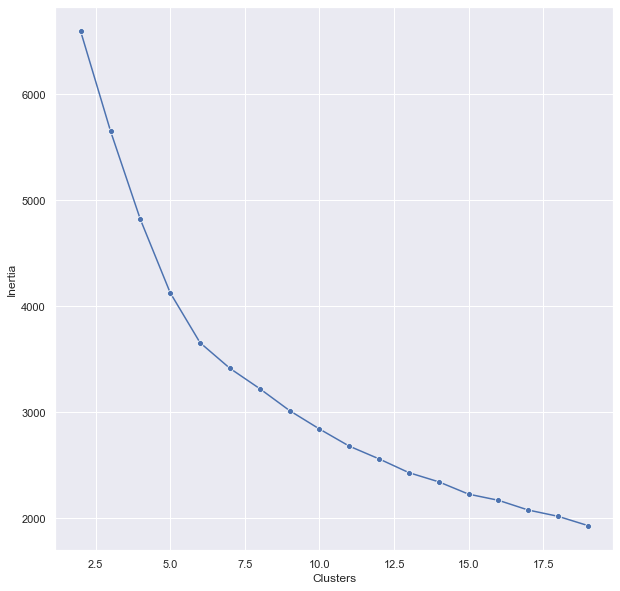

In [94]:
plt.figure(figsize=(10,10))
sns.lineplot(data = pd.DataFrame.from_dict(data), x= 'Clusters', y= 'Inertia', marker="o")

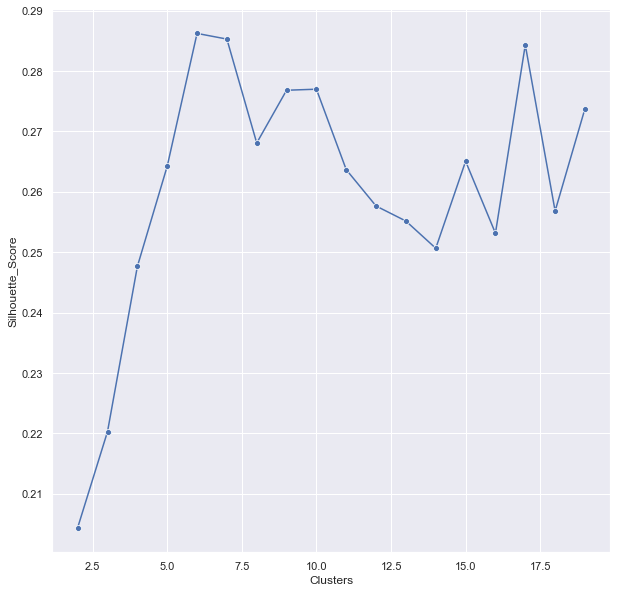

In [95]:
plt.figure(figsize=(10,10))
sns.lineplot(data = pd.DataFrame.from_dict(data), x= 'Clusters', y= 'Silhouette_Score', marker="o")

<li> Through K means clustering we cannot exactly find a convinient point of inflexion in the inertia vs Clusters plot. This means that K means wasnt able to cluster the data entirely but it could for atmost 16 clusters with good silhouette score.
<li> The above stated point can be further consolidated with the fact that our silhouette scores are almost near to 0 which signifies that our instances are mostly lying at the boundary of the clusters rather than lying exactly inside the clusters.
<li> Now we will try to implement Gaussian mixture model and try to find out whether our data contains cluster or not.
<li> Gaussian mixture model are better in a way that it determines the probablity of an instance belonging to a particular cluster based on mean, covariance and density of points while k means decides on the basis euclidean distance from the centroid of a cluster

### Gaussian Mixture model

In [96]:
from sklearn.mixture import GaussianMixture
bic_score = []
s_score = []
for k in range(2,20):
    gmm = GaussianMixture(k, n_init= 10)
    ypred = gmm.fit_predict(X_c)
    s_score.append(silhouette_score(X_c, ypred))
    bic_score.append(gmm.bic(X_c))

In [97]:
data = {'n_clusters':range(2,20),'silhouette score':s_score,'BIC score':bic_score,'Gradient BIC score':np.gradient(bic_score)}

#### Plotting silhouette score vs number of clusters

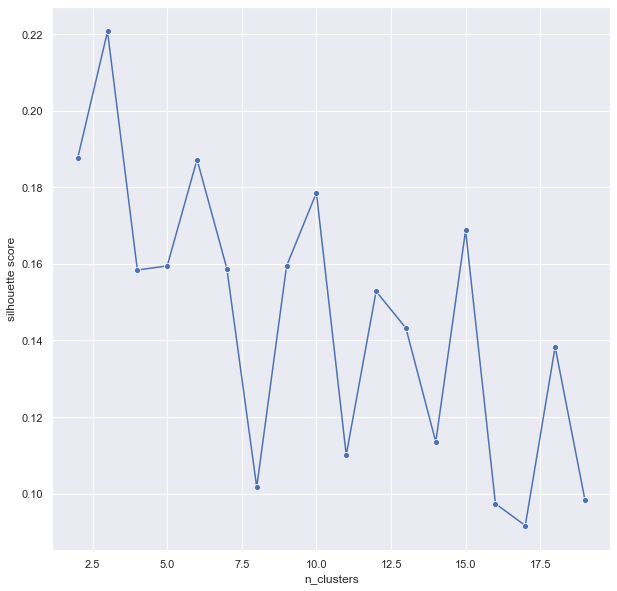

In [98]:
plt.figure(figsize=(10,10))
sns.lineplot(data = pd.DataFrame.from_dict(data), x= 'n_clusters', y= 'silhouette score', marker="o")

#### Plotting gradient BIC score vs number of cluster

<li> Gradient of BIC scores would provide us a better estimate for the number of appropriate clusters since it will give us an exact idea about the point of inflexion or the point from where the BIC score stops varying and the curve almost flattens out

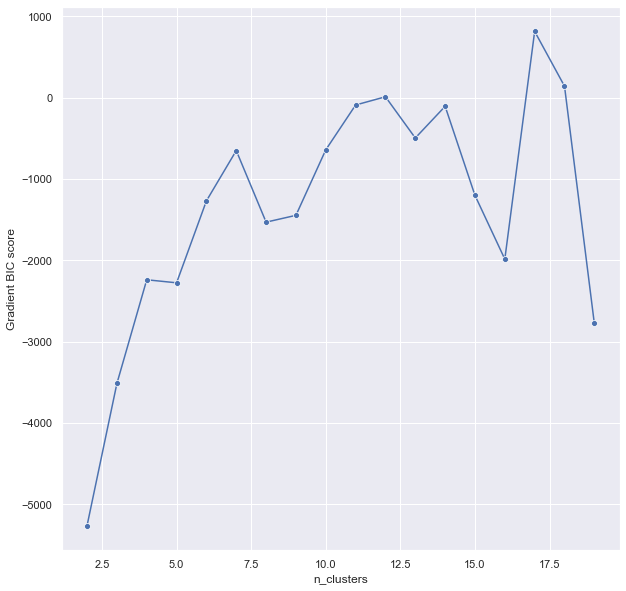

In [99]:
plt.figure(figsize=(10,10))
sns.lineplot(data = pd.DataFrame.from_dict(data), x= 'n_clusters', y= 'Gradient BIC score', marker="o")

<b>Observations :</b><li> From above unsupervised analysis we can observe that Gaussian mixture models are not performing better than K-mean which we expected becuase maximum silhouette score is less than what we obtained from K means and also we cannot find an exact cluster value on the gradien BIC graph after which the gradient change limits to 0 .<li> This nullifies our assumption that our dataset has been generated from the mixture of several Gaussian distributions. <li> Also , our attempt to cluster this data is not very successful.

## Train-Test split(70:30)

In [100]:
df1 = df.copy()

In [101]:
y = df1['strength'] #---->Target Variable
X = df1.drop(columns=['strength','age_in_months']) #----->Dependent Variables

In [102]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#### Testing the effectiveness of our custom scaler with the standard one

In [103]:
scaler = CustomStandardScaler()
xt = X_train.copy()
scaler.fit_transform(xt,y_train)

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
0,-0.448400,-0.878480,1.071386,-0.373609,0.084083,1.069681,0.087124,-0.501766
1,1.569552,-0.606512,0.406606,-0.937976,0.904453,-0.085460,-0.738003,-0.673779
2,-1.539337,1.081957,-0.826201,0.472941,-1.037648,-0.824543,1.494182,0.686684
3,2.078279,-0.878480,-0.826201,0.849185,-1.037648,1.956063,-1.966387,-0.673779
4,1.371713,0.326112,-0.826201,-1.337736,1.724823,-1.570087,1.434624,-0.611229
...,...,...,...,...,...,...,...,...
716,-0.630222,-0.878480,0.740557,-1.064959,0.418928,0.441718,1.639355,-0.501766
717,-1.055104,0.593547,1.180622,-0.303063,0.268247,0.422337,-0.308689,-0.501766
718,1.503605,1.127285,-0.826201,0.190758,0.820741,-1.146277,-0.788875,-0.673779
719,-0.276940,-0.878480,0.667212,0.463535,-0.150309,-0.319331,1.063627,0.155009


In [104]:
scaler.get_feature_names()

Index(['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age'],
      dtype='object')

In [105]:
xt.isnull().sum()

cement          0
slag            0
ash             0
water           0
superplastic    0
coarseagg       0
fineagg         0
age             0
dtype: int64

## Linear Regression

In [106]:
steps = [('c_scaler',CustomStandardScaler()),('linear',LinearRegression())]
pipe = Pipeline(steps)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'c_scaler', 'linear', 'linear__copy_X', 'linear__fit_intercept', 'linear__n_jobs', 'linear__normalize'])

In [107]:
params = dict()
params['linear__copy_X'] = [True, False]
params['linear__fit_intercept'] = [True, False]
params['linear__normalize'] = [False]
lreg = RandomizedSearchCV(pipe, params, n_iter=100, scoring='r2', n_jobs=-1, cv=5, random_state=1)
lreg.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('c_scaler',
                                              CustomStandardScaler()),
                                             ('linear',
                                              LinearRegression(copy_X=True,
                                                               fit_intercept=True,
                                                               n_jobs=None,
                                                               normalize=False))],
                                      verbose=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'linear__copy_X': [True, False],
                                        'linear__fit_intercept': [True, False],
                                        'linear__normalize': [False]},
                   pre_dispatch='2*n_jobs', random_state

In [108]:
lreg.best_params_

{'linear__normalize': False,
 'linear__fit_intercept': True,
 'linear__copy_X': True}

In [109]:
print("Train R2 score = {}".format(lreg.best_score_))
y_pred = lreg.predict(X_test)
print("Test R2 score = {}".format(r2_score(y_test,y_pred)))

Train R2 score = 0.6120224366598127
Test R2 score = 0.5781900091243368


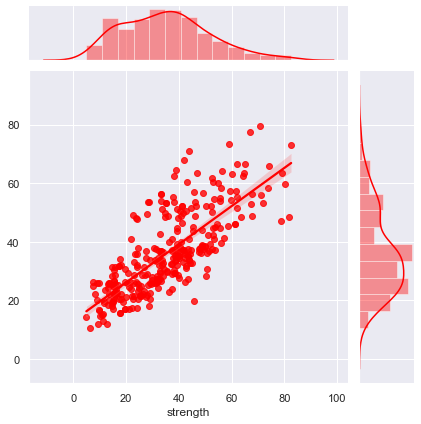

In [394]:
sns.jointplot(x=y_test,y=y_pred,kind='reg',color='red')

In [395]:
coef = lreg.best_estimator_.named_steps['linear'].coef_
featurenames = lreg.best_estimator_.named_steps['c_scaler'].get_feature_names()
feat_imp = list(zip(coef,featurenames))
feat_imp.sort(key = lambda x: x[0])
feat_imp[::-1]

[(13.128161879947253, 'cement'),
 (9.389141473887921, 'slag'),
 (7.346892479694518, 'age'),
 (5.830821381923805, 'ash'),
 (1.8902698194727878, 'fineagg'),
 (1.7339347789195854, 'superplastic'),
 (1.4630963335921066, 'coarseagg'),
 (-3.1528568853169032, 'water')]

Text(0.5, 1.0, 'Feature Importances of Linear Regression Model')

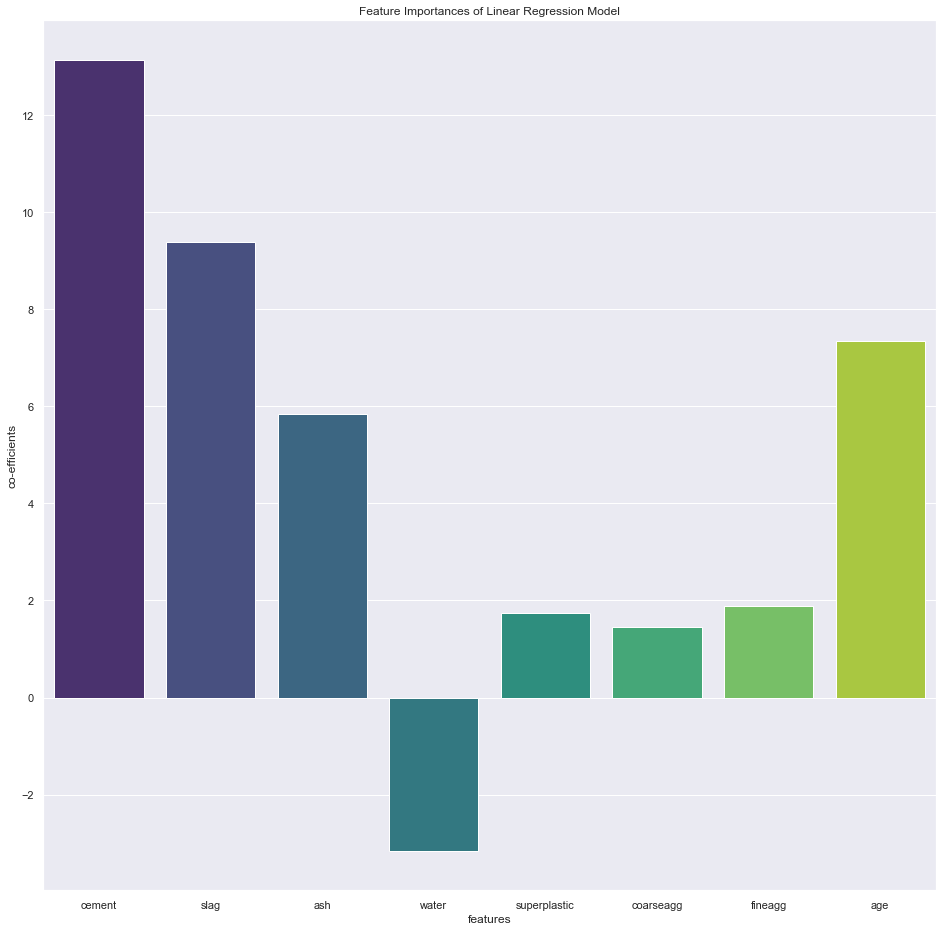

In [396]:
plt.figure(figsize = (16, 16))
sns.barplot(featurenames, coef, palette = 'viridis')

plt.ylabel('co-efficients')
plt.xlabel('features')
plt.title('Feature Importances of Linear Regression Model')

### Ridge regression

In [397]:
steps = [('c_scaler',CustomStandardScaler()),('ridge',Ridge())]
pipe = Pipeline(steps)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'c_scaler', 'ridge', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [398]:
params = dict()
params['ridge__alpha'] = [1,0.1,0.01,0.001,0.0001,0]
params['ridge__fit_intercept'] = [True, False]
params['ridge__normalize'] = [False]
params['ridge__solver'] = ['auto']
ridge = RandomizedSearchCV(pipe, params, n_iter=100, scoring='r2', n_jobs=-1, cv=5, random_state=1)
ridge.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('c_scaler',
                                              CustomStandardScaler()),
                                             ('ridge',
                                              Ridge(alpha=1.0, copy_X=True,
                                                    fit_intercept=True,
                                                    max_iter=None,
                                                    normalize=False,
                                                    random_state=None,
                                                    solver='auto',
                                                    tol=0.001))],
                                      verbose=False),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'ridge__alpha': [1, 0.1, 0.01, 0.001,
                                 

In [399]:
ridge.best_params_

{'ridge__solver': 'auto',
 'ridge__normalize': False,
 'ridge__fit_intercept': True,
 'ridge__alpha': 1}

In [400]:
print("Train R2 score = {}".format(ridge.best_score_))
y_pred = ridge.predict(X_test)
print("Test R2 score = {}".format(r2_score(y_test,y_pred)))

Train R2 score = 0.6121670055893293
Test R2 score = 0.5788754321267424


In [401]:
coef = ridge.best_estimator_.named_steps['ridge'].coef_
featurenames = ridge.best_estimator_.named_steps['c_scaler'].get_feature_names()
feat_imp = list(zip(coef,featurenames))
feat_imp.sort(key = lambda x: x[0])
feat_imp[::-1]

[(12.831476229093123, 'cement'),
 (9.099488976076403, 'slag'),
 (7.325966653669303, 'age'),
 (5.578848113491101, 'ash'),
 (1.7226473387147643, 'superplastic'),
 (1.6276777245558736, 'fineagg'),
 (1.2575406542530687, 'coarseagg'),
 (-3.368540015721204, 'water')]

Text(0.5, 1.0, 'Feature Importances of Ridge Regression Model')

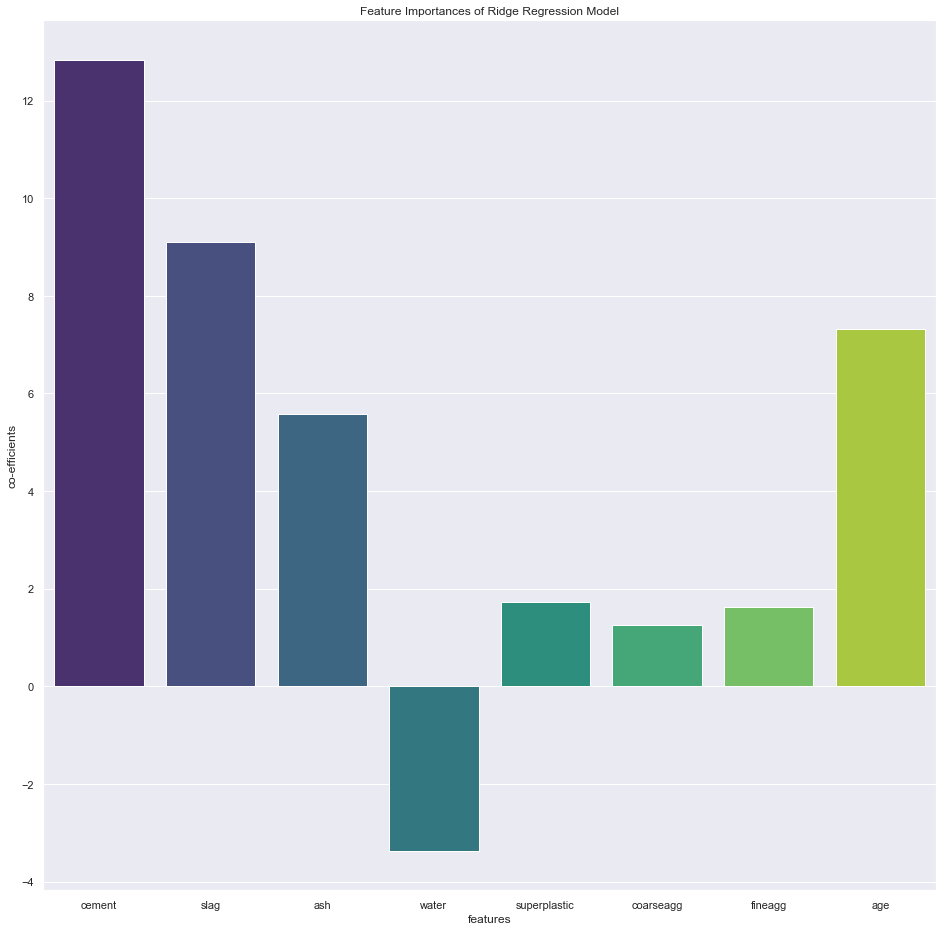

In [402]:
plt.figure(figsize = (16, 16))
sns.barplot(featurenames, coef, palette = 'viridis')

plt.ylabel('co-efficients')
plt.xlabel('features')
plt.title('Feature Importances of Ridge Regression Model')

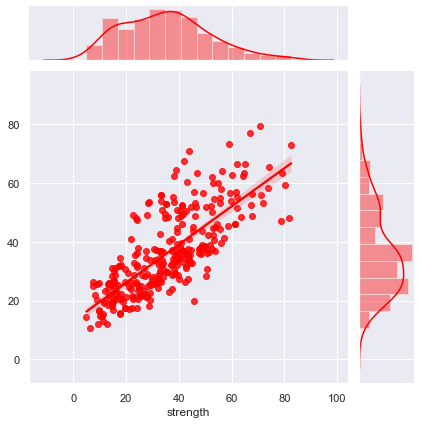

In [403]:
sns.jointplot(x=y_test,y=y_pred,kind='reg',color='red')

### Polynomial regression degree 2 

In [406]:
x_train

array([[ 0.        , -1.22423609,  1.33925942, ..., -1.62783676,
        -0.3138796 , -0.31806006],
       [ 0.        ,  1.06117754, -0.83031305, ..., -0.1934174 ,
        -0.67753839, -0.69759261],
       [ 0.        ,  0.47973294,  0.85084017, ..., -2.32805959,
         4.94832824,  4.03416852],
       ...,
       [ 0.        ,  2.08951756, -0.83031305, ..., -0.76138521,
        -0.70583464, -0.73606835],
       [ 0.        ,  1.00351361, -0.59436173, ...,  0.42481917,
         0.15137418,  0.29448922],
       [ 0.        , -0.42751283, -0.83031305, ...,  1.46674442,
        -0.20218881, -0.26196377]])

In [410]:
scl = StandardScaler()
poly=PolynomialFeatures(degree=2,interaction_only=True)
X_poly=poly.fit_transform(X)
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the 
x_train, x_test, y_tr, y_t = train_test_split(X_poly, y, test_size=test_size, random_state=seed)
x_train = scl.fit_transform(x_train)
x_test = scl.fit_transform(x_test)
poly_model=LinearRegression()
poly_model.fit(x_train,y_tr)
ypred_tr = poly_model.predict(x_train)
ypred_test = poly_model.predict(x_test)
print('Score for degree as {}:'.format(2))
print('Train score:')
print("R2 = {}".format(r2_score(ypred_tr,y_tr)))
print(poly_model.score(x_train,y_tr))
print('Test score:')
print("R2 = {}".format(r2_score(ypred_test,y_t)))
print(poly_model.score(x_test,y_t))
    

Score for degree as 2:
Train score:
R2 = 0.6836180809353061
0.7596579575557465
Test score:
R2 = 0.6655074985554952
0.741046352915975


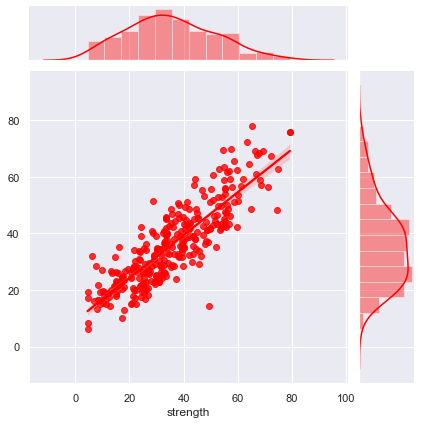

In [411]:
sns.jointplot(x=y_t,y=ypred_test,kind='reg',color='red')

#### After applying polynomial regression of degree 2 there is some improvement in the test score

### Random Forest regression

In [429]:
from sklearn.ensemble import RandomForestRegressor
steps = [('c_scaler',CustomStandardScaler()),('rf',RandomForestRegressor())]
pipe = Pipeline(steps)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'c_scaler', 'rf', 'rf__bootstrap', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_state', 'rf__verbose', 'rf__warm_start'])

In [ ]:
params = dict()
params['rf__max_depth'] = range(3,7)
params['rf__n_estimators'] = [1,3,5,50,100,1000]
rf = RandomizedSearchCV(pipe, params, n_iter=100, scoring='r2', n_jobs=-1, cv=5, random_state=1)
rf.fit(X_train, y_train)

In [415]:
rf.best_params_

{'rf__n_estimators': 1000, 'rf__max_depth': 6}

In [416]:
print("Train R2 score = {}".format(rf.best_score_))
y_pred = rf.predict(X_test)
print("Test R2 score = {}".format(r2_score(y_test,y_pred)))

Train R2 score = 0.8060085308865135
Test R2 score = 0.8459209669722672


In [417]:
coef = rf.best_estimator_.named_steps['rf'].feature_importances_
featurenames = rf.best_estimator_.named_steps['c_scaler'].get_feature_names()
feat_imp = list(zip(coef,featurenames))
feat_imp.sort(key = lambda x: x[0])
feat_imp[::-1]

[(0.36684295876402506, 'age'),
 (0.3170277083275484, 'cement'),
 (0.09706209196758454, 'water'),
 (0.08410829408451488, 'superplastic'),
 (0.0764262401607665, 'slag'),
 (0.033179584384050255, 'fineagg'),
 (0.013536860512047003, 'ash'),
 (0.011816261799463193, 'coarseagg')]

Text(0.5, 1.0, 'Feature Importances of Random Forest Regression Model')

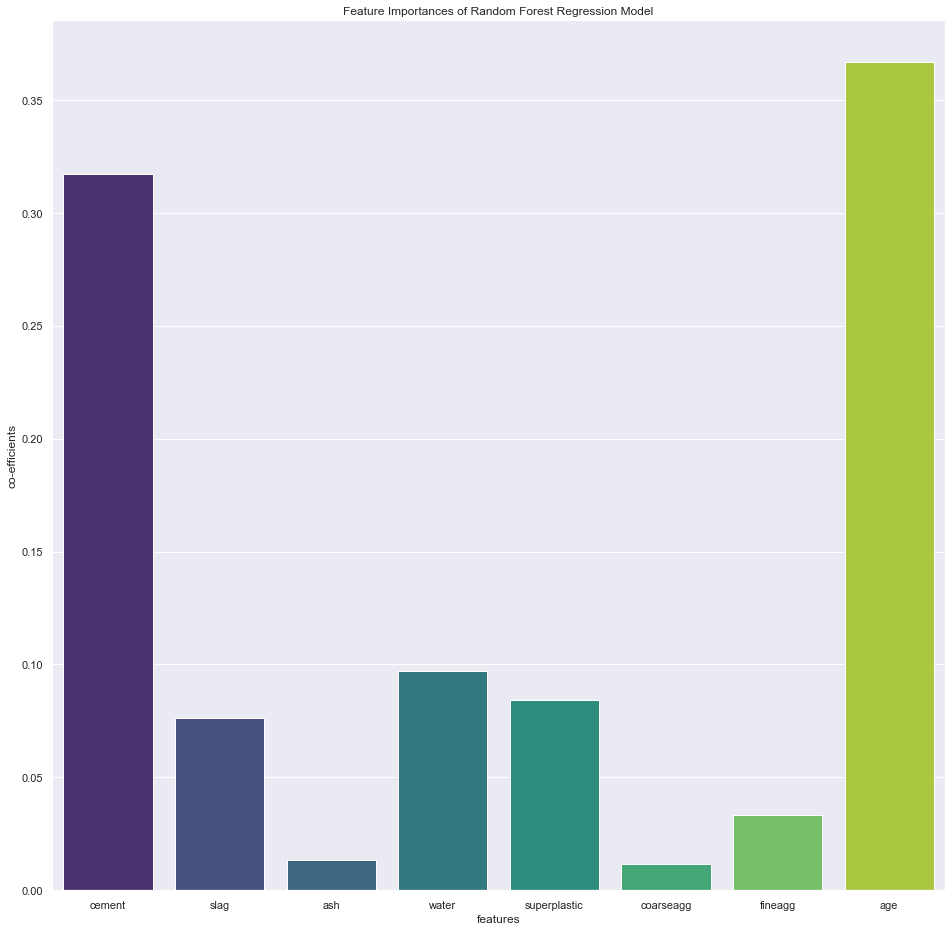

In [419]:
plt.figure(figsize = (16, 16))
sns.barplot(featurenames, coef, palette = 'viridis')

plt.ylabel('co-efficients')
plt.xlabel('features')
plt.title('Feature Importances of Random Forest Regression Model')

#### Here our model performance has improved alot after applying random forest regression

In [125]:
n_iter = 100
scr = []
for i in range(0,100):
    rf_model = RandomForestRegressor(n_estimators=1000, max_depth=6)
    rf_model.fit(X_train,y_train)
    y_pre = rf_model.predict(X_test)
    scr.append(r2_score(y_pre,y_test))

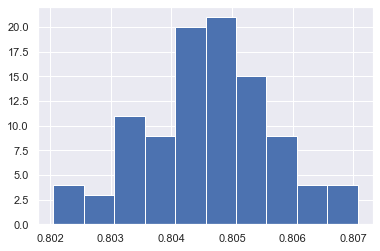

95.0 confidence interval 80.2% and 80.7%


In [126]:
from matplotlib import pyplot
pyplot.hist(scr)
pyplot.show()
alpha = 0.95                            
p = ((1.0-alpha)/2.0) * 100             
lower = max(0.0, np.percentile(scr, p))  
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(scr, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100))

### Xgboost Regression

In [420]:
steps = [('c_scaler',CustomStandardScaler()),('xgb',XGBRegressor())]
pipe = Pipeline(steps)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'c_scaler', 'xgb', 'xgb__base_score', 'xgb__booster', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__gamma', 'xgb__importance_type', 'xgb__learning_rate', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__min_child_weight', 'xgb__missing', 'xgb__n_estimators', 'xgb__n_jobs', 'xgb__nthread', 'xgb__objective', 'xgb__random_state', 'xgb__reg_alpha', 'xgb__reg_lambda', 'xgb__scale_pos_weight', 'xgb__seed', 'xgb__silent', 'xgb__subsample', 'xgb__verbosity'])

In [421]:
params = dict()
params['xgb__n_estimators'] = [1,3,5,50,100,1000]
xg = RandomizedSearchCV(pipe, params, n_iter=100, scoring='r2', n_jobs=-1, cv=5, random_state=1)
xg.fit(X_train, y_train)

[21:40:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('c_scaler',
                                              CustomStandardScaler()),
                                             ('xgb',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           gamma=0,
                                                           importance_type='gain',
                                                           learning_rate=0.1,
                                                           max_delta_step=0,
             

In [422]:
xg.best_params_

{'xgb__n_estimators': 100}

In [423]:
print("Train R2 score = {}".format(xg.best_score_))
y_pred = xg.predict(X_test)
print("Test R2 score = {}".format(r2_score(y_test,y_pred)))

Train R2 score = 0.8189682880884778
Test R2 score = 0.8670958123725129


In [425]:
coef = xg.best_estimator_.named_steps['xgb'].feature_importances_
featurenames = xg.best_estimator_.named_steps['c_scaler'].get_feature_names()
feat_imp = list(zip(coef,featurenames))
feat_imp.sort(key = lambda x: x[0])
feat_imp[::-1]

[(0.2701759, 'cement'),
 (0.26743755, 'age'),
 (0.14903939, 'superplastic'),
 (0.100487866, 'water'),
 (0.08709738, 'slag'),
 (0.06264321, 'ash'),
 (0.04845551, 'fineagg'),
 (0.01466323, 'coarseagg')]

Text(0.5, 1.0, 'Feature Importances of XG boost Regression Model')

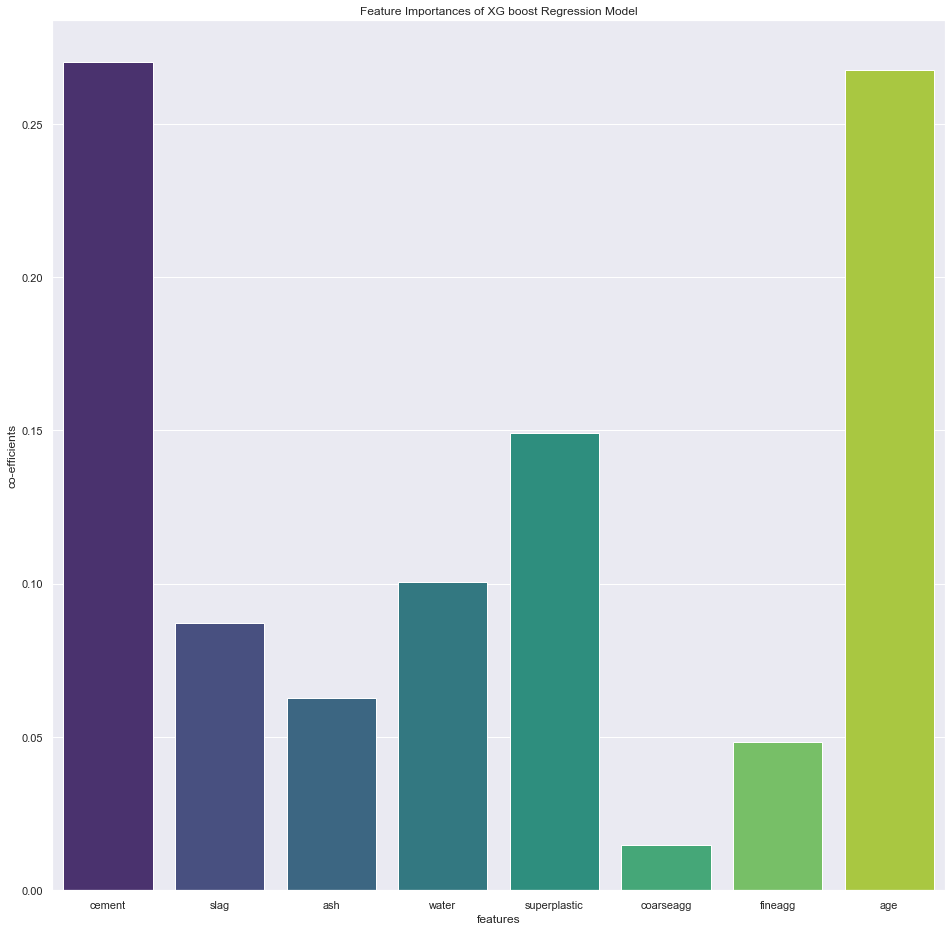

In [426]:
plt.figure(figsize = (16, 16))
sns.barplot(featurenames, coef, palette = 'viridis')

plt.ylabel('co-efficients')
plt.xlabel('features')
plt.title('Feature Importances of XG boost Regression Model')

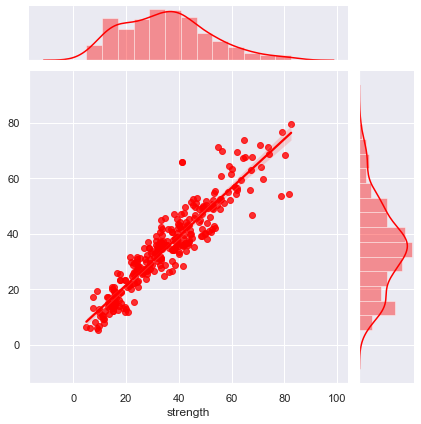

In [428]:
sns.jointplot(x=y_test,y=y_pred,kind='reg',color='red')

<b><h1>Final Conclusions:</b><li>Simple linear regressions have performed more or less same with test r2 score of 0.57 approx.
<li>There was some improvement in the predictability of the models once we applied polynomial regression with degree of polynomial.<li>We observed massive improvement with Decision tree regressors like Random forest regressor where test r2 jumped to 0.84.<li>Also we observed further improvement in test r2 score once we applied boosting in form of xgboost . The test r2 score jumped to 0.87. <li> We trained our data with outliers but still we were able to get decent score with bagging and boosting algorithms which proves that these algorithms are more effective to predict a continous target. <li> We have also used pipelines and custom transformers to scale test and train data separately.